In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

'''
Input: 
    2 coordinates of line segment
Output: 
    Hough parameters theta and rho, and length of line
    theta is the slope angle of normal line of line
    rho is the distance to origin with sign depending on sign of x intersect 
    range of theta is within -pi/2 to pi/2
    range of rho is within -maxRho to maxRho, where maxRho is the length of diagnoal line of image
    To distinguish 2 line segments with same distance to origin and slope but in different sides of origin,
    we define that for line with negative x intersect, rho is negative with abs equal to distance to origin. 
'''
def computehoughTransformCoord(x1, y1, x2, y2):

    if y1 == y2:
        theta = np.pi/2
        rho = abs(y1)
        length = abs(x1 - x2)
        return theta, rho, length

    k_inv =  (x1 - x2) / (y1 - y2)
    theta = np.arctan(-k_inv)

    A = y2 - y1
    B = x2 - x1
    C = abs(x2*y1 - x1*y2)
    length = np.sqrt(A**2 + B**2)
    rho = C / length

    # distinguish same distance and theta but different sides
    X0 = - k_inv * y1 + x1
    if X0 < 0:
        rho = -rho
    
    return theta, rho, length

def average_grayscale_along_line(image, x1, y1, x2, y2):
    # Calculate the length of the line
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Calculate the unit direction vector
    vx = (x2 - x1) / L
    vy = (y2 - y1) / L
    
    # Initialize a list to store average grayscale values
    average_grayscales = []
    
    # Iterate over each point along the line
    for i in range(int(L) + 1):
        x = int(x1 + i * vx)
        y = int(y1 + i * vy)
        
        # Initialize a list to store grayscale values
        grayscale_values = []
        
        # Iterate over 5 points to the left and 5 points to the right of the current point
        for j in range(-9, 10):
            x_neighbor = x + j
            if x_neighbor >= 0 and x_neighbor < image.shape[1]:
                grayscale_value = image[y, x_neighbor]
                grayscale_values.append(grayscale_value)
        
        # Calculate the average grayscale value for the current point
        average_grayscale = np.mean(grayscale_values)
        average_grayscales.append(average_grayscale)
    average_grayscale = np.mean(average_grayscales)
    
    return average_grayscale

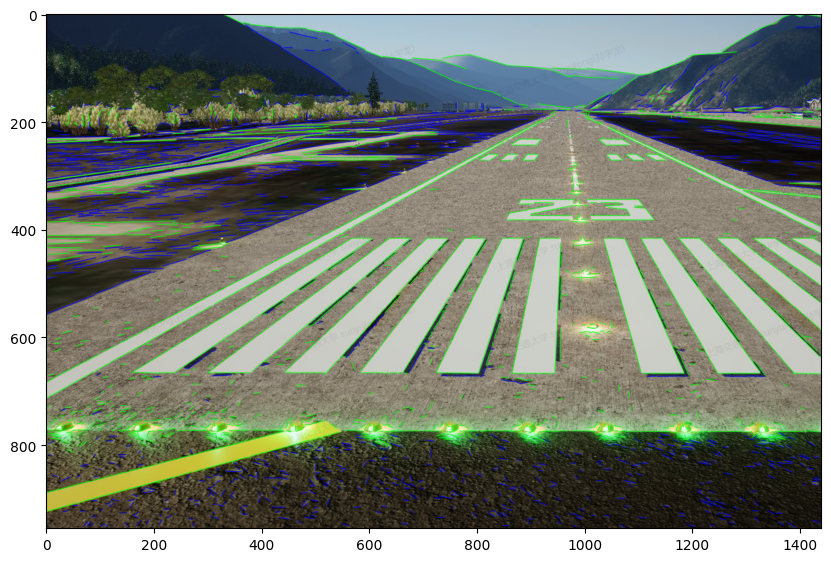

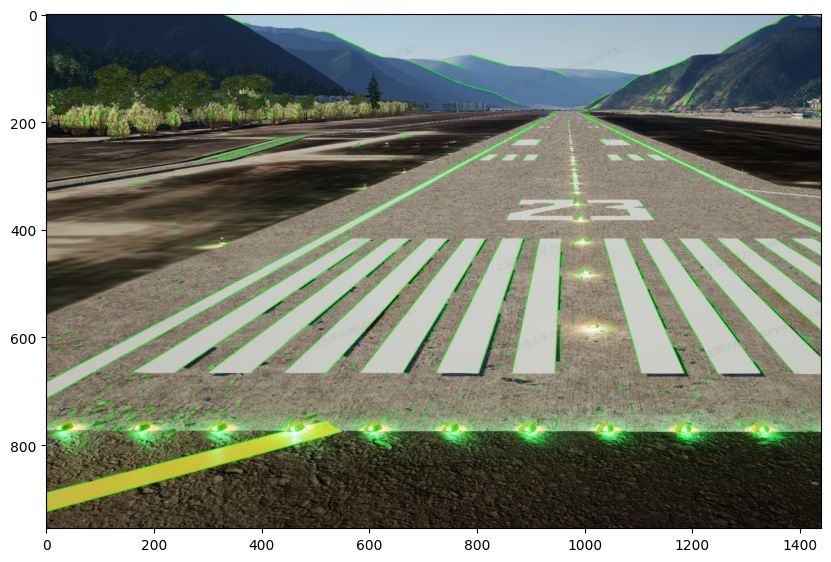

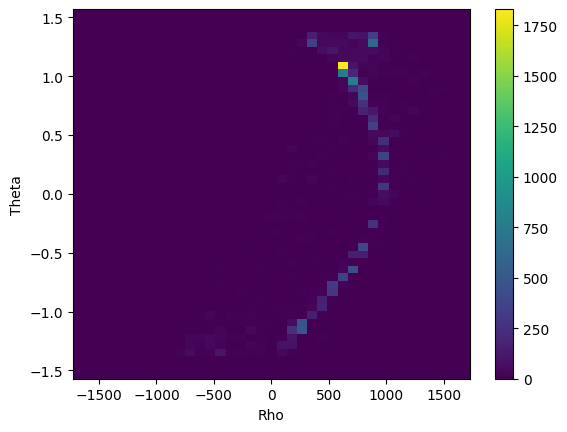

In [55]:
img = cv2.imread("images/541.jpg")
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,0]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lsd = cv2.createLineSegmentDetector(scale=0.8, sigma_scale=0.6, quant=2.0, ang_th=22.5, log_eps=0.0, density_th=0.7, n_bins=1024)
# lsd = cv2.createLineSegmentDetector(0)
lines, width, prec, nfa = lsd.detect(gray)

thred = 100

drawn_img = img.copy()
for line in lines:
    x1, y1, x2, y2 = map(int, line[0])
    average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
    if average_grayscale < thred:
        drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (255, 0, 0), 1, cv2.LINE_AA)
    else:
        drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=[10, 10])
plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))

LLL = 2

thetaList = []
dList = []
rhoList = []
lineList = []
for line in lines:
    line = line[0]

    average_grayscale = average_grayscale_along_line(gray, line[0], line[1], line[2], line[3])
    if average_grayscale < thred:
        continue

    theta, rho, d = computehoughTransformCoord(line[0], line[1], line[2], line[3])
    if d < LLL:
        continue
    if abs(np.abs(theta) - np.pi/2) < np.pi / 16 or np.abs(theta) > 1.5707963:
        continue

    thetaList.append(theta)
    dList.append(d)
    rhoList.append(rho)
    lineList.append(line)

drawn_img = img.copy()
for line in lineList:
    x1, y1, x2, y2 = map(int, line)
    if np.sqrt((x1 - x2)**2 + (y1 - y2)**2) < 0:
        continue

    average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
    if average_grayscale < thred:
        drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (255, 0, 0), 1, cv2.LINE_AA)
    else:
        drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
    
plt.figure(figsize=[10, 10])
plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))
cv2.imwrite("drawn_img.jpg", drawn_img)

N = 60
Ntheta = 50
Nrho = 60
maxRho = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
# 创建一个网格
theta_bins = np.linspace(-np.pi/2, np.pi/2, num=Ntheta)
rho_bins = np.linspace(-maxRho, maxRho, num=Nrho)
totalLengthGrid = np.zeros((len(theta_bins) - 1, len(rho_bins) - 1))
thetaRhoGrid = [[[] for _ in range(len(rho_bins) - 1)] for _ in range(len(theta_bins) - 1)]

# 映射thetaList和rhoList到网格中
for theta, rho, d, line in zip(thetaList, rhoList, dList, lineList):
    theta_idx = np.digitize(theta, theta_bins) - 1
    rho_idx = np.digitize(rho, rho_bins) - 1
    # print(theta, rho, theta_idx, rho_idx)
    totalLengthGrid[theta_idx, rho_idx] += d
    thetaRhoGrid[theta_idx][rho_idx].append((theta, rho, line, d))

# 绘制热力图
plt.figure()
plt.imshow(totalLengthGrid, extent=(rho_bins[0], rho_bins[-1], theta_bins[0], theta_bins[-1]), aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Rho')
plt.ylabel('Theta')
plt.show()

# 找到最大元素的索引
max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
max_d = totalLengthGrid[max_index]

# 将最大元素设为负无穷
totalLengthGrid[max_index] = -np.inf

# 找到第二大元素的索引
second_max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
second_max_d = totalLengthGrid[second_max_index]

totalLengthGrid[second_max_index] = -np.inf

third_max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
third_max_d = totalLengthGrid[third_max_index]


===========total d: 777.3015041882234==============
[239.40227 665.6652  329.48853 604.54236] 108.86477090428569
[384.02933 567.6122  449.5798  523.42883] 79.05082729649945
[449.84296 523.21985 605.4525  417.8702 ] 187.91721900686787
[502.1717  493.02957 474.42883 512.6868 ] 34.00108785201837
[323.2725  649.5768  301.46112 665.5189 ] 27.01643358721654
[551.47906 458.77426 527.1582  474.8047 ] 29.128660766472745
[333.62628 641.97546 323.13452 648.80884] 12.520863938628091
[631.6216  421.53427 617.1751  432.27856] 18.003899431636004
[610.8345  436.71936 583.29553 457.10538] 34.263434194825955
[344.07187 594.5449  381.85727 569.3484 ] 45.415875727943686
[558.2074  475.30862 533.547   493.69113] 30.757957067251617
[450.6833  554.8962  416.89957 579.8505 ] 42.000705190480055
[855.2995  236.42278 860.9639  232.34587] 6.979032975074047
[328.92316 604.97284 343.7394  594.70764] 18.024862204931594
[400.2941  592.6296  391.06946 598.79047] 11.092814357726423
[856.86993 261.8678  845.80786 269.63

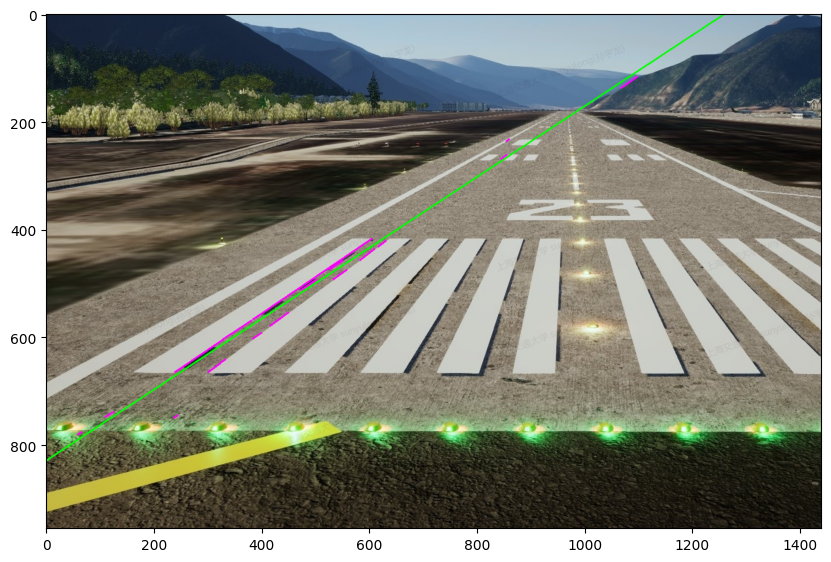

In [53]:
def drawResult(grid: list, lineImg, color = (0, 0, 255)):
    # 假设 max_index 是一个包含多个元组 (theta, rho) 的列表
    thetas = [pair[0] for pair in grid]
    rhos = [pair[1] for pair in grid]
    lines = [pair[2] for pair in grid]
    ds = [pair[3] for pair in grid]

    x = []
    y = []
    weights = []
    for line, d in zip(lines, ds):
        x.append(line[0])
        x.append(line[2])
        y.append(line[1])
        y.append(line[3])
        weights.append(d)
        weights.append(d)

    A = np.vstack([x, np.ones(len(x))]).T
    w = np.diag(np.sqrt(weights))
    m, c = np.linalg.lstsq(w @ A, y @ w, rcond=None)[0]

    theta = np.arctan(-1/m)
    rho = c * np.sin(theta)

    # thetas = np.asarray(thetas)
    # rhos = np.asarray(rhos)
    # ds = np.asarray(ds)
    
    # theta = np.sum(thetas * ds)/np.sum(ds)
    # rho = np.sum(rhos * ds)/np.sum(ds)

    # m = 1/np.tan(-theta)
    # c = rho / np.sin(theta)
    
    # 在图像上绘制直线
    print(f"===========total d: {np.sum(ds)}==============")
    LL = 3000
    cv2.line(lineImg, (0, int(c)), (LL, int( LL *m + c)), color, 2)
    for line, d in zip(lines, ds):
        ...
        cv2.line(lineImg, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), (255, 0, 255), 2)
        print(line, d)

lineImg = img.copy()
# drawResult(thetaRhoGrid[max_index[0]][max_index[1]], lineImg, color = (0, 0, 255))
drawResult(thetaRhoGrid[second_max_index[0]][second_max_index[1]], lineImg, color = (0, 255, 0))
# drawResult(thetaRhoGrid[third_max_index[0]][third_max_index[1]], lineImg, color=(255, 0, 0))

plt.figure(figsize=[10, 10])
plt.imshow(cv2.cvtColor(lineImg, cv2.COLOR_BGR2RGB))

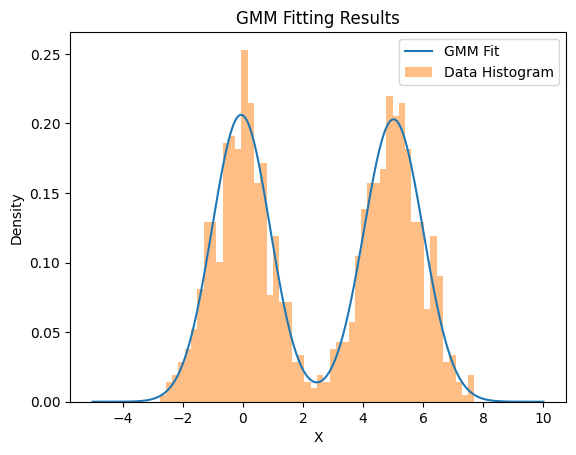

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 生成一些示例数据
data = np.concatenate([np.random.normal(0, 1, 500), np.random.normal(5, 1, 500)]).astype(np.float32)
data = data.reshape(-1, 1)

# 创建GMM对象
gmm = cv2.ml.EM_create()

# 设置GMM参数
gmm.setClustersNumber(2)  # 设置高斯分布的数量
gmm.setCovarianceMatrixType(cv2.ml.EM_COV_MAT_DIAGONAL)  # 设置协方差矩阵类型

# 拟合数据
gmm.trainEM(data)

# 获取拟合结果
means = gmm.getMeans()
covs = gmm.getCovs()
weights = gmm.getWeights()

# 可视化结果
x = np.linspace(-5, 10, 1000)
y = np.zeros_like(x)

for i in range(len(means)):
    mean = means[i][0]
    cov = covs[i][0]
    weight = weights[0][i]
    y += weight * np.exp(-0.5 * ((x - mean) / np.sqrt(cov)) ** 2) / np.sqrt(2 * np.pi * cov)

plt.plot(x, y, label='GMM Fit')
plt.hist(data, bins=50, density=True, alpha=0.5, label='Data Histogram')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('GMM Fitting Results')
plt.legend()
plt.show()
